# GitHub Issue Processing Agent using Amazon Bedrock, LangGraph and MCP

This notebook demonstrates an agent built with Amazon Bedrock, LangGraph that interacts with the GitHub MCP server to automate the process of handling GitHub issues.

**Functionality:**
1.  **Fetch Open Issues:** Retrieves open issues from a specified GitHub repository.
2.  **Analyze Issue:** Uses an LLM to analyze the first fetched issue to determine if code changes are needed, no changes are needed, or clarification is required.
3.  **Plan Changes (if needed):** If code changes are required, uses a ReAct agent (LLM + tools) to explore relevant files and formulate a plan.
4.  **Implement Changes (if needed):** If a plan exists, uses an LLM and GitHub tools to modify the necessary files in a new branch.
5.  **Create Pull Request (if needed):** If files were successfully changed, creates a pull request.
6.  **Handle Other Cases:** Includes nodes to handle scenarios where no code changes are needed or where clarification/errors occur.

## 1. Installation

In [ ]:
!pip install langchain langchain-core langchain-aws langchain-mcp-adapters mcp langgraph boto3 nest_asyncio

In [47]:

# Function to unset GitHub token from environment variables
def unset_github_token():
    import os
    if 'GITHUB_TOKEN' in os.environ:
        del os.environ['GITHUB_TOKEN']

unset_github_token()

## 2. Configuration

Set up global variables for repository details, API tokens, and LLM configuration.

In [ ]:
import os
import getpass
import nest_asyncio
from langchain_aws import ChatBedrockConverse
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field
from typing import TypedDict, List, Optional, Dict, Any
import json
import base64
from mcp import ClientSession, StdioServerParameters
from mcp.client.stdio import stdio_client
from langchain_mcp_adapters.tools import load_mcp_tools
from langgraph.prebuilt import create_react_agent
from langgraph.graph import StateGraph, START, END
from langchain.schema import SystemMessage, HumanMessage
from IPython.display import Image, display


# Apply nest_asyncio to allow running async code in Jupyter/IPython
nest_asyncio.apply()

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("GITHUB_TOKEN")

# --- GitHub Configuration ---
GITHUB_OWNER = "<github_handle>"
GITHUB_REPO = "<repo_name>"
BASE_BRANCH = "main"

# --- LLM Configuration ---
BEDROCK_MODEL_ID = "us.anthropic.claude-3-5-haiku-20241022-v1:0"  # Changed to Haiku for potentially faster/cheaper execution
BEDROCK_PROFILE_NAME = "" # Replace with your AWS profile if needed, or remove if using default credentials

# --- MCP Server Configuration ---
# Note: The ghcr.io/github/github-mcp-server needs Docker installed and running.
# Ensure the GITHUB_TOKEN is correctly passed to the Docker container environment.
mcp_config = {
    "mcp": {
        "inputs": [
            {
                "type": "promptString",
                "id": "github_token",
                "description": "GitHub Personal Access Token",
                "password": "true",
            }
        ],
        "servers": {
            "github": {
                "command": "finch",
                "args": [
                    "run",
                    "-i",
                    "--rm",
                    "-e",
                    "GITHUB_PERSONAL_ACCESS_TOKEN",
                    "ghcr.io/github/github-mcp-server",
                ],
                "env": {"GITHUB_PERSONAL_ACCESS_TOKEN": os.environ.get("GITHUB_TOKEN")},
            }
        },
    }
}

# --- Helper Function for MCP Tools ---
async def get_mcp_tools(session: ClientSession) -> List[Any]:
    """Loads tools from the connected MCP session."""
    # Ensure session is initialized (might already be done by caller)
    # await session.initialize() # Caller should handle initialization
    tools = await load_mcp_tools(session)
    return tools

# --- StdioServerParameters Setup ---
# Create server parameters for stdio connection using the config
server_params = StdioServerParameters(
    command=mcp_config["mcp"]["servers"]["github"]["command"],
    args=mcp_config["mcp"]["servers"]["github"]["args"],
    env=mcp_config["mcp"]["servers"]["github"]["env"]
)

## 3. Initialize LLM

In [34]:
llm = ChatBedrockConverse(
    model=BEDROCK_MODEL_ID,
    temperature=0,
    max_tokens=4096, # Increased max_tokens for potentially complex outputs
    credentials_profile_name=BEDROCK_PROFILE_NAME if BEDROCK_PROFILE_NAME else None
    # other params...
)

## 4. Define Agent State and Schema for structured output

Define the structure for data that flows between the nodes of the graph.

In [ ]:
# --- Agent State Definition ---
class AgentState(TypedDict):
    issues: List[Dict[str, Any]] # Store full issue details
    current_issue_index: int # Track which issue is being processed
    analysis_result: Optional[Dict[str, Any]] # Store structured analysis
    action_required: Optional[str] # Extracted action: 'code_change_required', 'no_change_needed', 'needs_clarification', 'error'
    code_change_plan: Optional[Dict[str, Any]] # Store structured plan
    fetched_files_content: Optional[Dict[str, Any]] # {file_path: {'content': str, 'sha': str}}
    changed_files: Optional[List[str]]
    branch_name: Optional[str]
    pr_url: Optional[str]
    error_message: Optional[str]
    final_summary: Optional[str]



We need to define schema for structured output from LLM

In [ ]:
# --- Pydantic Models for Structured Output ---


class IssueAnalysis(BaseModel):
    """Analysis of the GitHub issue."""

    analysis: str = Field(
        description="Brief summary of the issue's core problem or request."
    )
    action_required: str = Field(
        description="Decision on next step. Must be one of: 'code_change_required', 'no_change_needed', 'needs_clarification'."
    )
    relevant_files: Optional[List[str]] = Field(
        description="List of file paths likely needing inspection or modification if action_required is 'code_change_required'.",
        default=None,
    )
    reasoning: str = Field(
        description="Justification for the action_required decision."
    )


class FileChangeSpecification(BaseModel):
    """Details about a specific file change needed."""

    file_path: str = Field(description="Full path to the file that needs changes")
    # current_code: Optional[str] = Field(description="Current code that needs to be changed (if available)") # Removed, less reliable for LLM
    suggested_changes: str = Field(
        description="Detailed explanation of changes needed for this file, including specific lines or sections if possible."
    )
    priority: str = Field(
        description="Priority level: 'high', 'medium', 'low'", default="medium"
    )


class CodeChangesPlan(BaseModel):
    """Complete plan for code changes to address an issue."""

    summary: str = Field(
        description="Overall summary of the changes needed to resolve the issue."
    )
    file_changes: List[FileChangeSpecification] = Field(
        description="List of specific file changes required. Include *only* files that need modification."
    )
    commit_message: str = Field(
        description="A concise and informative commit message summarizing the changes."
    )
    implementation_notes: Optional[str] = Field(
        description="Optional: Additional notes for implementing these changes, like dependencies or tests.",
        default=None,
    )

## 5. Define Graph Nodes

Each function represents a node in the LangGraph agent.

#### 5.1  **Fetch Open Issues:** Retrieves open issues from a specified GitHub repository

This async function connects to the GitHub MCP server to retrieve all open issues from the configured repository. It:

1. Establishes a connection to the MCP server
2. Loads available tools from the server
3. Finds and invokes the `list_issues` tool to fetch open issues
4. Returns a dictionary containing the fetched issues and the current issue index
5. Handles exceptions by returning an error message if the fetch operation fails

In [36]:
# --- Node Function Definitions ---

async def fetch_all_issues(state: AgentState) -> Dict[str, Any]:
    """Fetches all open issues from the configured repository."""
    print(f"--- Fetching issues for {GITHUB_OWNER}/{GITHUB_REPO} ---")
    try:
        async with stdio_client(server_params) as (read, write):
            async with ClientSession(read, write) as session:
                await session.initialize()
                tools = await get_mcp_tools(session)
                print(f"Loaded {len(tools)} tools from MCP server.")
                list_issues_tool = next((t for t in tools if t.name == "list_issues"), None)

                if not list_issues_tool:
                    raise ValueError("list_issues tool not found in MCP server.")

                issues_str = await list_issues_tool.ainvoke(
                    {"owner": GITHUB_OWNER, "repo": GITHUB_REPO, "state": "open"}
                )
                issues = json.loads(issues_str)
                print(f"Fetched {len(issues)} open issue(s).")
                return {"issues": issues, "current_issue_index": 0 if issues else -1}
    except Exception as e:
        print(f"Error fetching issues: {e}")
        return {"error_message": f"Failed to fetch issues: {str(e)}", "issues": [], "current_issue_index": -1}



#### 5.2  **Analyze Issue:** Uses an LLM to analyze the first fetched issue to determine if code changes are needed, no changes are needed, or clarification is required.

This function analyzes GitHub issues using an LLM to determine the appropriate action. It processes the current issue, classifies it as requiring code changes, needing clarification, or requiring no changes, and returns the analysis results with the determined action.

In [37]:
async def analyze_issue(state: AgentState) -> Dict[str, Any]:
    """Analyzes the current issue using the LLM to determine required action."""
    print("--- Analyzing Issue ---")
    issues = state.get("issues", [])
    idx = state.get("current_issue_index", -1)
    print(f"Current Issue Index: {idx}")
    print(f"Number of Issues: {len(issues)}")

    if idx < 0 or idx >= len(issues):
        print("No more issues to analyze or invalid index.")
        # Decide how to end - maybe a specific state or just end silently
        return {"final_summary": "No remaining issues to process.", "action_required": "stop"} # Use 'stop' to signal end

    issue = issues[idx]
    print(f"Analyzing Issue #{issue['number']}: {issue['title']}")

    try:
        structured_llm = llm.with_structured_output(IssueAnalysis)
        prompt = ChatPromptTemplate.from_messages([
            SystemMessage(content="You are a GitHub issue analyzer. Your goal is to determine the necessary action based on the issue description. Respond *only* with the structured format requested."),
            HumanMessage(
                content=(
                    f"Analyze the following GitHub issue:\n\n"
                    f"Issue Number: {issue.get('number', 'N/A')}\n"
                    f"Title: {issue.get('title', 'N/A')}\n"
                    f"Body:\n{issue.get('body', '')}\n\n"
                    f"Determine the required action. The 'action_required' field *must* be one of: 'code_change_required', 'no_change_needed', 'needs_clarification'. Provide your reasoning."
                    f"If the issue involves updating dependencies (like mentioning package.json, requirements.txt, versions), it's likely 'code_change_required'."
                )
            ),
        ])
        chain = prompt | structured_llm
        analysis = await chain.ainvoke({})

        print(f"Analysis result: {analysis}")
        return {"analysis_result": analysis.dict(), "action_required": analysis.action_required}
    except Exception as e:
        print(f"Error analyzing issue #{issue.get('number', 'N/A')}: {e}")
        return {"error_message": f"Failed to analyze issue #{issue.get('number', 'N/A')}: {str(e)}", "action_required": "error"}


#### 5.3.  **Plan Changes (if needed):** If code changes are required, uses a ReAct agent (LLM + tools) to explore relevant files and formulate a plan.

In [38]:
async def identify_required_changes(state: AgentState) -> Dict[str, Any]:
    """Uses a ReAct agent to explore code and plan changes."""
    print("--- Identifying Required Code Changes ---")
    issues = state.get("issues", [])
    idx = state.get("current_issue_index", -1)
    analysis_result = state.get("analysis_result")

    if idx < 0 or idx >= len(issues) or not analysis_result:
        return {"error_message": "Missing issue data or analysis for planning.", "action_required": "error"}

    current_issue = issues[idx]
    print(f"Planning changes for Issue #{current_issue['number']}")

    try:
        async with stdio_client(server_params) as (read, write):
            async with ClientSession(read, write) as session:
                await session.initialize()
                tools = await get_mcp_tools(session)
                relevant_tools = [
                    tool for tool in tools if tool.name in [
                        "search_code", "get_file_contents", # Core tools
                        # "list_code_scanning_alerts", "search_repositories", "get_pull_request_files" # Less critical for this task
                    ]
                ]
                if not relevant_tools:
                    raise ValueError("Required planning tools (search_code, get_file_contents) not found.")

                agent = create_react_agent(llm, relevant_tools, debug=True)

                # Use analysis to guide the agent
                initial_files = analysis_result.get("relevant_files", [])
                file_hint = f"Initial analysis suggests looking at these files: {', '.join(initial_files)}." if initial_files else ""

                issue_prompt = (
                    f"Task: Plan code changes for GitHub Issue #{current_issue['number']} in the repository {GITHUB_OWNER}/{GITHUB_REPO}.\n\n"
                    f"Issue Title: {current_issue['title']}\n"
                    f"Issue Body:\n{current_issue['body']}\n\n"
                    f"Analysis Summary: {analysis_result.get('analysis', 'N/A')}. {file_hint}\n\n"
                    f"Instructions:\n"
                    f"1. Use 'search_code' if needed to confirm file locations or find relevant code snippets within the {GITHUB_OWNER}/{GITHUB_REPO} repository."
                    f"2. Use 'get_file_contents' to fetch the content of necessary files (like those mentioned in the analysis or found via search)."
                    f"3. Examine the file contents in relation to the issue.\n"
                    f"4. Determine the *exact* changes needed (e.g., specific lines to modify, new code to add)."
                    f"5. Your final output should be a plan detailing which files to change and the specific modifications required for each."
                )

                agent_response = await agent.ainvoke({"messages": [HumanMessage(content=issue_prompt)]})
                agent_findings = agent_response["messages"][-1].content
                print("Agent exploration finished.")

        # Use structured output LLM to create the final plan based on agent findings
        structured_llm_plan = llm.with_structured_output(CodeChangesPlan)
        plan_prompt = ChatPromptTemplate.from_messages([
            SystemMessage(content="You are a meticulous software engineer. Based on the provided GitHub issue and the findings from code exploration, create a structured plan for the necessary code changes. Focus only on the changes required by the issue. Respond *only* with the structured format requested."),
            HumanMessage(
                content=(
                    f"GitHub Issue #{current_issue['number']}: {current_issue['title']}\n\n"
                    f"Code Exploration Findings:\n{agent_findings}\n\n"
                    f"Generate the CodeChangesPlan based *only* on these findings and the original issue request. Ensure the commit message is appropriate."
                )
            ),
        ])
        plan_chain = plan_prompt | structured_llm_plan
        change_plan = await plan_chain.ainvoke({})

        print(f"Generated code change plan with {len(change_plan.file_changes)} file modification(s).")
        return {"code_change_plan": change_plan.dict()}

    except Exception as e:
        print(f"Error identifying required changes: {e}")
        return {"error_message": f"Failed to plan changes for issue #{current_issue.get('number', 'N/A')}: {str(e)}", "action_required": "error"}

#### 5.4  **Implement Changes (if needed):** If a plan exists, uses an LLM and GitHub tools to modify the necessary files in a new branch.


This function uses a ReAct agent to explore repository code and plan necessary changes for GitHub issues. It connects to the MCP server, creates an agent with code search capabilities, explores code based on issue details, and generates a structured change plan with specific file modifications.

In [39]:
async def implement_code_changes(state: AgentState) -> Dict[str, Any]:
    """Applies the planned code changes to the repository."""
    print("--- Implementing Code Changes ---")
    change_plan = state.get("code_change_plan")
    issues = state.get("issues", [])
    idx = state.get("current_issue_index", -1)

    if not change_plan or idx < 0 or idx >= len(issues):
        return {"error_message": "Missing change plan or issue data.", "action_required": "error"}

    current_issue = issues[idx]
    file_changes_spec = change_plan.get("file_changes", [])
    commit_message = change_plan.get("commit_message", f"Fix issue #{current_issue['number']}")
    branch_name = f"fix-issue-{current_issue['number']}-{base64.b32encode(os.urandom(3)).decode('ascii').lower()}" # Add randomness

    if not file_changes_spec:
        print("Plan contains no file changes. Skipping implementation.")
        # This might indicate a planning error or a case where analysis was wrong.
        # Route to error or clarification?
        return {"error_message": "Code change plan was empty.", "action_required": "error", "branch_name": None, "changed_files": []}

    changed_files_list = []
    update_errors = []

    try:
        async with stdio_client(server_params) as (read, write):
            async with ClientSession(read, write) as session:
                await session.initialize()
                tools = await get_mcp_tools(session)

                create_branch_tool = next((t for t in tools if t.name == "create_branch"), None)
                get_file_tool = next((t for t in tools if t.name == "get_file_contents"), None)
                update_file_tool = next((t for t in tools if t.name == "create_or_update_file"), None)

                if not (create_branch_tool and get_file_tool and update_file_tool):
                    raise ValueError("Missing required GitHub tools (create_branch, get_file_contents, create_or_update_file).")

                # 1. Create Branch
                try:
                    print(f"Creating branch: {branch_name}")
                    await create_branch_tool.ainvoke({
                        "owner": GITHUB_OWNER,
                        "repo": GITHUB_REPO,
                        "branch": branch_name,
                        "from_branch": BASE_BRANCH
                    })
                except Exception as e:
                    # Handle case where branch might already exist (e.g., from a previous failed run)
                    if "Reference already exists" in str(e):
                        print(f"Branch '{branch_name}' already exists. Proceeding...")
                    else:
                        raise RuntimeError(f"Failed to create branch '{branch_name}': {e}")

                # 2. Iterate through file changes
                for change_spec in file_changes_spec:
                    file_path = change_spec.get("file_path")
                    suggested_changes = change_spec.get("suggested_changes")
                    if not file_path or not suggested_changes:
                        update_errors.append(f"Skipping invalid change spec: {change_spec}")
                        continue

                    print(f"Processing file: {file_path}")
                    try:
                        # Get current file content and SHA
                        file_info_str = await get_file_tool.ainvoke({
                            "owner": GITHUB_OWNER,
                            "repo": GITHUB_REPO,
                            "path": file_path,
                            "branch": BASE_BRANCH # Get content from base branch
                        })
                        file_info = json.loads(file_info_str)
                        current_content_encoded = file_info.get("content")
                        current_sha = file_info.get("sha")

                        if not current_content_encoded or not current_sha:
                             raise ValueError(f"Could not get content or SHA for {file_path}")

                        current_content = base64.b64decode(current_content_encoded).decode('utf-8')

                        # Use LLM to generate the *full* updated content
                        update_prompt = ChatPromptTemplate.from_messages([
                            SystemMessage(content="You are an expert code editor. Given the current file content and requested changes, provide the *complete* updated file content. Output *only* the raw file content, without any explanations, introductions, or markdown formatting like ```."),
                            HumanMessage(
                                content=(
                                    f"File Path: {file_path}\n\n"
                                    f"Current Content:\n```\n{current_content}\n```\n\n"
                                    f"Requested Changes:\n{suggested_changes}\n\n"
                                    f"Provide the complete, updated file content below:"
                                )
                            ),
                        ])
                        update_chain = update_prompt | llm
                        update_result = await update_chain.ainvoke({})
                        updated_content_text = update_result.content.strip()

                        # Basic cleanup - remove potential markdown fences if LLM didn't follow instructions
                        if updated_content_text.startswith("```") and updated_content_text.endswith("```"):
                             lines = updated_content_text.splitlines()
                             if len(lines) > 1:
                                 updated_content_text = "\n".join(lines[1:-1])
                             else:
                                  updated_content_text = "" # Avoid committing just fences
                        elif updated_content_text.startswith("```"):
                             lines = updated_content_text.splitlines()
                             if len(lines) > 0:
                                updated_content_text = "\n".join(lines[1:])

                        if not updated_content_text:
                             raise ValueError("LLM produced empty content after cleanup.")

                        # Update the file in the new branch
                        file_commit_message = f"Update {file_path} for issue #{current_issue['number']}"
                        await update_file_tool.ainvoke({
                            "owner": GITHUB_OWNER,
                            "repo": GITHUB_REPO,
                            "path": file_path,
                            "message": file_commit_message, # Use specific message per file
                            "content": updated_content_text,
                            "branch": branch_name,
                            "sha": current_sha
                        })
                        print(f"Successfully updated {file_path} in branch {branch_name}")
                        changed_files_list.append(file_path)

                    except Exception as file_e:
                        err_msg = f"Error processing file {file_path}: {str(file_e)}"
                        print(err_msg)
                        update_errors.append(err_msg)

        # After loop, prepare state update
        result = {"branch_name": branch_name, "changed_files": changed_files_list}
        if update_errors:
            result["error_message"] = "\n".join(update_errors)
            result["action_required"] = "error"
        elif not changed_files_list:
             result["error_message"] = "No files were successfully changed despite plan."
             result["action_required"] = "error"
        # If successful, action_required doesn't need explicit update here, routing will handle it.
        return result

    except Exception as e:
        print(f"Fatal error during code implementation: {e}")
        return {"error_message": f"Failed to implement changes: {str(e)}", "action_required": "error", "branch_name": branch_name, "changed_files": changed_files_list}



#### 5.5  **Create Pull Request (if needed):** If files were successfully changed, creates a pull request.



This function creates a GitHub pull request for implemented code changes. It connects to the MCP server, generates a descriptive PR title and body based on the issue and changes, and creates the pull request linking the branch with implemented changes to the base branch.


In [40]:
async def create_pr(state: AgentState) -> Dict[str, Any]:
    """Creates a pull request for the implemented changes."""
    print("--- Creating Pull Request ---")
    branch_name = state.get("branch_name")
    changed_files = state.get("changed_files", [])
    issues = state.get("issues", [])
    idx = state.get("current_issue_index", -1)
    change_plan = state.get("code_change_plan")

    if not branch_name or not changed_files or idx < 0 or idx >= len(issues) or not change_plan:
        print("Skipping PR creation: Missing required information (branch, changed files, issue, plan).")
        # This path might not be strictly necessary if routing handles it, but good safeguard.
        return {"error_message": "Cannot create PR due to missing information.", "action_required": "error"}

    current_issue = issues[idx]
    print(f"Creating PR for branch: {branch_name}")

    try:
        async with stdio_client(server_params) as (read, write):
            async with ClientSession(read, write) as session:
                await session.initialize()
                tools = await get_mcp_tools(session)
                create_pr_tool = next((t for t in tools if t.name == "create_pull_request"), None)

                if not create_pr_tool:
                    raise ValueError("create_pull_request tool not found.")

                # pr_title = f"Fix: {current_issue.get('title', f'issue {current_issue['number']}')} (Issue #{current_issue['number']})"
                pr_title = f"Fix issue #{current_issue['number']}: {current_issue.get('title', '')}"
                pr_body = (
                    f"## Description\n"
                    f"This PR addresses GitHub Issue #{current_issue['number']}.\n\n"
                    f"**Issue Title:** {current_issue.get('title', 'N/A')}\n"
                    f"**Link:** {current_issue.get('html_url', 'N/A')}\n\n"
                    f"## Changes Made\n"
                    f"{change_plan.get('summary', 'See commit history.')}\n\n"
                    f"**Files Modified:**\n"
                    + "\n".join([f"- `{f}`" for f in changed_files])
                    + (f"\n\n**Implementation Notes:**\n{change_plan.get('implementation_notes', '')}" if change_plan.get('implementation_notes') else "")
                )

                pr_response_str = await create_pr_tool.ainvoke({
                    "owner": GITHUB_OWNER,
                    "repo": GITHUB_REPO,
                    "title": pr_title,
                    "head": branch_name,
                    "base": BASE_BRANCH,
                    "body": pr_body,
                    "maintainer_can_modify": True # Optional: Allow maintainers to edit PR
                })

                pr_response = json.loads(pr_response_str)
                pr_url = pr_response.get("html_url")

                if pr_url:
                    print(f"Successfully created PR: {pr_url}")
                    summary = f"Processed Issue #{current_issue['number']}. Code changes implemented and PR created: {pr_url}"
                    return {"pr_url": pr_url, "final_summary": summary}
                else:
                    raise ValueError(f"PR creation response did not contain html_url. Response: {pr_response_str}")

    except Exception as e:
        err_msg = f"Error creating pull request for branch {branch_name}: {str(e)}"
        print(err_msg)
        return {"error_message": err_msg, "action_required": "error"}



#### 5.6  **Handle Other Cases:** Includes nodes to handle scenarios where no code changes are needed or where clarification/errors occur.


1. `handle_no_change`: Processes issues that don't require code changes, generating a summary with the analysis reasoning
2. `handle_clarification_or_error`: Manages issues that need clarification or encountered errors during processing, providing appropriate summary information


In [41]:
async def handle_no_change(state: AgentState) -> Dict[str, Any]:
    """Handles the case where the analysis determined no code changes are needed."""
    print("--- Handling No Change Needed ---")
    issues = state.get("issues", [])
    idx = state.get("current_issue_index", -1)
    analysis_result = state.get("analysis_result")

    if idx < 0 or idx >= len(issues) or not analysis_result:
         return {"final_summary": "No change needed, but issue/analysis context lost.", "action_required": "stop"}

    current_issue = issues[idx]
    summary = f"Issue #{current_issue['number']} analyzed. Reason: '{analysis_result.get('reasoning', 'N/A')}'. No code changes were deemed necessary."
    print(summary)
    # Optional: Add a comment to the GitHub issue using 'add_issue_comment' tool
    # (Requires adding tool call logic similar to other nodes)
    return {"final_summary": summary}

async def handle_clarification_or_error(state: AgentState) -> Dict[str, Any]:
    """Handles cases needing clarification or when an error occurred during processing."""
    print("--- Handling Clarification or Error ---")
    issues = state.get("issues", [])
    idx = state.get("current_issue_index", -1)
    error_message = state.get("error_message")
    analysis_result = state.get("analysis_result")
    action_required = state.get("action_required")

    issue_num = 'N/A'
    if idx >= 0 and idx < len(issues):
        issue_num = issues[idx].get('number', 'N/A')

    summary = f"Processing stopped for Issue #{issue_num}. "
    if error_message:
        summary += f"Reason: Error encountered - {error_message}"
        print(f"Error processing Issue #{issue_num}: {error_message}")
    elif action_required == "needs_clarification":
        reason = analysis_result.get('reasoning', 'Analysis indicated clarification needed.') if analysis_result else 'Analysis indicated clarification needed.'
        summary += f"Reason: Needs Clarification - {reason}"
        print(f"Issue #{issue_num} requires clarification: {reason}")
    else:
         summary += "Reason: Unknown state reached or unexpected action." 
         print(f"Issue #{issue_num} reached handle_clarification_or_error node unexpectedly.")

    # Optional: Add a comment to the GitHub issue
    # (Requires adding tool call logic)
    return {"final_summary": summary}

## 6. Define Graph Routing Logic

These functions determine the next node to execute based on the current state.

1. `route_after_fetch`: Determines next steps after issue fetching - proceeds to analysis if issues exist
2. `route_after_analysis`: Routes based on analysis outcome (code change, no change, or clarification)
3. `route_after_plan`: Directs workflow after planning - proceeds to implementation if valid plan exists
4. `route_after_implement`: Routes after code implementation - proceeds to PR creation if changes were made



In [42]:
# --- Conditional Edge Routing Functions ---

def route_after_fetch(state: AgentState) -> str:
    """Routes after fetching issues. Proceeds if issues found, stops if not or error."""
    if state.get("error_message"):
        return "handle_clarification_or_error"
    if state.get("issues") and state.get("current_issue_index", -1) >= 0:
        return "analyze_issue"
    else:
        print("No open issues found or fetch failed silently.")
        return END # End the graph if no issues

def route_after_analysis(state: AgentState) -> str:
    """Routes based on the analysis outcome."""
    action = state.get("action_required")
    print(f"Routing after analysis, action: {action}")
    if action == "code_change_required":
        return "identify_required_changes"
    elif action == "no_change_needed":
        return "handle_no_change"
    elif action == "needs_clarification":
        return "handle_clarification_or_error"
    elif action == "stop": # Handle case where analyze_issue decided to stop
         return END
    else: # Includes action == "error" or unexpected values
        return "handle_clarification_or_error"

def route_after_plan(state: AgentState) -> str:
    """Routes after planning changes. Proceeds if plan exists, handles error otherwise."""
    if state.get("error_message"):
        return "handle_clarification_or_error"
    if state.get("code_change_plan") and state["code_change_plan"].get("file_changes"):
        return "implement_code_changes"
    else:
        print("No valid code change plan generated or plan has no files.")
        # Update state to reflect this specific error before routing
        state["error_message"] = state.get("error_message", "Code change plan was invalid or empty.")
        return "handle_clarification_or_error"

def route_after_implement(state: AgentState) -> str:
    """Routes after attempting implementation. Proceeds to PR if successful, handles error otherwise."""
    if state.get("error_message"): # Checks for errors during implementation
        return "handle_clarification_or_error"
    if state.get("changed_files") and state.get("branch_name"):
        return "create_pr"
    else:
        print("Implementation did not result in changed files or branch name.")
        state["error_message"] = state.get("error_message", "Implementation failed to produce changes or branch.")
        return "handle_clarification_or_error"

## 7. Build and Compile the Graph

This code constructs the LangGraph workflow for the GitHub issue processing agent. It creates a state graph with defined agent nodes for each processing step, establishes conditional edges between nodes using routing functions, and defines the complete workflow path from issue fetching to PR creation with alternative paths for special cases.


In [43]:
graph_builder = StateGraph(AgentState)

# Add nodes
graph_builder.add_node("fetch_all_issues", fetch_all_issues)
graph_builder.add_node("analyze_issue", analyze_issue)
graph_builder.add_node("identify_required_changes", identify_required_changes)
graph_builder.add_node("implement_code_changes", implement_code_changes)
graph_builder.add_node("create_pr", create_pr)
graph_builder.add_node("handle_no_change", handle_no_change)
graph_builder.add_node("handle_clarification_or_error", handle_clarification_or_error)

# Define edges
graph_builder.add_edge(START, "fetch_all_issues")

# Conditional routing after fetching
graph_builder.add_conditional_edges(
    "fetch_all_issues",
    route_after_fetch,
    {
        "analyze_issue": "analyze_issue",
        "handle_clarification_or_error": "handle_clarification_or_error",
        END: END
    }
)

# Conditional routing after analysis
graph_builder.add_conditional_edges(
    "analyze_issue",
    route_after_analysis,
    {
        "identify_required_changes": "identify_required_changes",
        "handle_no_change": "handle_no_change",
        "handle_clarification_or_error": "handle_clarification_or_error",
         END: END # Route for 'stop' action
    }
)

# Conditional routing after planning
graph_builder.add_conditional_edges(
    "identify_required_changes",
    route_after_plan,
    {
        "implement_code_changes": "implement_code_changes",
        "handle_clarification_or_error": "handle_clarification_or_error"
    }
)

# Conditional routing after implementation
graph_builder.add_conditional_edges(
    "implement_code_changes",
    route_after_implement,
    {
        "create_pr": "create_pr",
        "handle_clarification_or_error": "handle_clarification_or_error"
    }
)

# Edges leading to the end
graph_builder.add_edge("create_pr", END)
graph_builder.add_edge("handle_no_change", END)
graph_builder.add_edge("handle_clarification_or_error", END)

# Compile the graph
graph = graph_builder.compile()

print("Graph compiled successfully.")

Graph compiled successfully.


## 8. Visualize the Graph

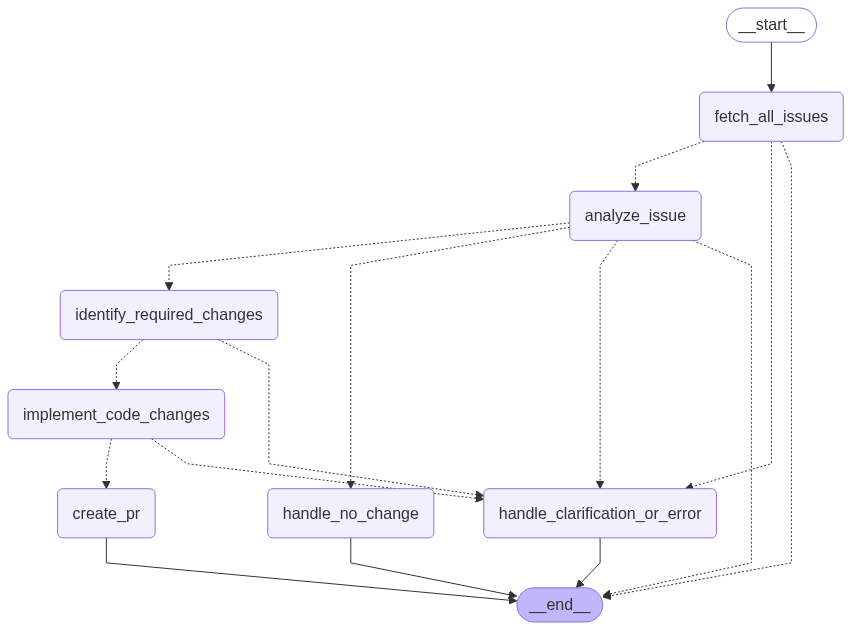

In [ ]:
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Could not generate graph visualization: {e}\n(Ensure graphviz or mermaid-cli is installed and in PATH)")

## 9. Run the Agent

In [ ]:
import asyncio
async def run_graph():
    print("--- Running GitHub Issue Agent ---")
    # Initial state can be empty, START node ('fetch_all_issues') will populate it
    initial_state = {"current_issue_index": 2}
    final_state = await graph.ainvoke(initial_state, config={"recursion_limit": 15}) # Add recursion limit

    print("\n--- Agent Run Finished ---")
    print("Final State:")
    # Pretty print the final state
    print(json.dumps(final_state, indent=2, default=str)) # Use default=str for non-serializable items
    print("\nFinal Summary:", final_state.get("final_summary", "N/A"))

# Execute the async function
# asyncio.run() might cause issues in notebooks, nest_asyncio handles this.
asyncio.get_event_loop().run_until_complete(run_graph())

### Cleanup 

- Delete any IAM roles and policies created specifically for this post
- If you have created SageMaker Notebook instance to run this sample then do not forget to delete the instance
- If you no longer need access to an Amazon Bedrock FM, you can remove access from it. For instructions, see Add or remove access to Amazon Bedrock foundation models.
- Delete the personal access token, for instructions, see Deleting a personal access token.
